In [1]:
# import modin.pandas as pd
import pandas as pd
import numpy as np
from Utilities.dataimport import ImportData
from Utilities.models import countVectorizorByCategory
import dateparser as dp

output_files = '/Users/bradkittrell/Desktop/smartphones/brands'
data = ImportData(output_files)
df = data.combineCSV().drop_duplicates(subset='title')
df.to_csv('df.csv')

#extensive date cleaning is required for the release date. that is handled here
#generate features with regex
import time
import datetime as dt
today = dt.datetime.now()
date_dictionary = {'Q1':'January','Q2':'April','Q3':'July','Q4':'September','3Q':'July','Sep':'September','Oct':'October'}

df.released = df.released.str.replace(r'(\w.+(Released ))',"")
df.released = df.released.str.replace(r'((Exp\. announcement ))',"")
df.released = df.released.str.replace(r'((Not).*)',"")
df['releaseYear'] = df.released.str.extract(r'(\d+)')
df['releaseMonth'] = df.released.str.extract(r'((?<=\, )\w+)')

df.replace({'releaseMonth': date_dictionary},inplace=True)
df['released'] = pd.to_datetime(df.releaseYear+" "+df.releaseMonth,format='%Y %B')
df['ageInYears'] = (today-df.released)/np.timedelta64(1,'Y')

#generate features with regex
import re
import time
import datetime as dt
today = dt.datetime.now()
"""
extract data from the scraped columns using regex

"""
df['lowPrice'] = df.basePrice.str.replace(r'(\u2009)|(\,)',"")

df['lowPriceUSD'] = df.lowPrice.str.extract(r'((?<=\$)\w+.\d+)').astype('float64').fillna(0)
df['batteryEnergy'] = df.batterySize.str.extract(r'(\d+)').astype('float64').fillna(0)
df['frontCameraMP'] = df.frontCamera.str.extract(r'(\d+(?=\sMP))').astype('float64').fillna(0)
df['memory'] = df.memory.str.replace(r'(\((.*?)\))',"")
df['pricing'] = df.pricing.str.replace(r'((\xE2)..)','')
# df['memory'] = df.memory.str.replace(r'(.\w+.(RAM)|\w+.\w+.(RAM)|.\w+.(ROM))',"")
# df['memory'] = df.memory.str.replace(r'(\w.*(\/)\w+)',"")
df['baseCapacitySize'] = df.memory.str.extract(r'(\d+)')[0].astype('float64').fillna(0)
df['operatingSystem'] = df.opSys.str.extract(r'(\w+)')[0]
df['screenSize'] = df.screen.str.extract(r'(\d+(\.\d))')[0].astype('float64').fillna(0)
df['screenBodyRatio'] = df.screen.str.extract(r'(\d+\.\d(?=\%))')[0].astype('float64').fillna(0)
df['brand'] = df.title.str.extract(r'(\w+)')[0].astype(str)
df['rearCameraCleaned'] = df.rearCamera.str.replace(r'((\u2424|\\r)|\((.*?)\))'," ")
df['numberOfRearLenses'] = df.rearCameraCleaned.str.count('MP')
df['rearCameraPrimaryMP'] = df.rearCameraCleaned.str.extract(r'(\d+.(?=MP))').astype('float64').fillna(0)
df['rearCameraMPList'] = df.rearCameraCleaned.str.findall(r'(\d+.(?=MP))')

In [2]:
modeling_df = df.dropna(subset=['releaseYear','sensors'])
modeling_df['releaseYear']=modeling_df.releaseYear.astype(str)

categories = countVectorizorByCategory(modeling_df,'sensors','releaseYear',tfidf=False)

categories.to_csv('vectorCategories.csv',index_label='index')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [3]:
#get top five
def returnBestbyCategory(dataframe,category,count,top):
    initial_df = pd.DataFrame(columns=dataframe.columns)
    category_unique = dataframe[category].unique()

    for cat in category_unique:
        filtered_df = dataframe[dataframe[category]==cat]
        filtered_df = filtered_df.sort_values(by=[count],ascending=False)
        filtered_df = filtered_df.head(top)
        initial_df = initial_df.append(filtered_df,ignore_index=True)
    return initial_df

cleaned_categories = categories[~categories['category'].isin(['2000','2002','2003','2005','2007'])]


topFiveFeatures = returnBestbyCategory(cleaned_categories,'category','count',5)


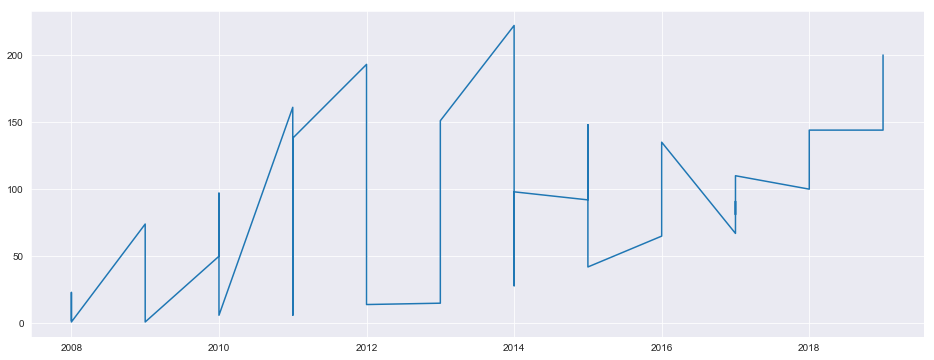

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
plt.figure(figsize=(16,6))

sorted_df = topFiveFeatures.sort_values(by=['category'])
sorted_df['yearNumeric'] = pd.to_numeric(sorted_df.category,errors='coerce')
# sns.scatterplot(x='category',y='count',hue='feature',data=sorted_for_plot_df )
plt.plot(sorted_df['yearNumeric'],sorted_df['count'])
plt.show()